## Nearest Earth Objects 1910-2024: Preprocessing

### Importing libraries

In [1]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Loading dataset

In [2]:
df = pd.read_csv("./data/raw_data.csv")

In [3]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [4]:
df.shape

(338199, 9)

### Analyzing features

In [5]:
FEATS = ['neo_id', 'name', 'absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'orbiting_body', 'relative_velocity',
       'miss_distance']

In [6]:
df[FEATS].select_dtypes(include=["float", "int"]).describe().T

,count,mean,std,min,25%,50%,75%,max
neo_id,338199.0,1.759939e+07,2.287225e+07,2.000433e+06,3.373980e+06,3.742127e+06,5.405374e+07,5.446281e+07
absolute_magnitude,338171.0,2.293252e+01,2.911216e+00,9.250000e+00,2.074000e+01,2.280000e+01,2.510000e+01,3.358000e+01
estimated_diameter_min,338171.0,1.578120e-01,3.138851e-01,5.111578e-04,2.538370e-02,7.320740e-02,1.890406e-01,3.754525e+01
estimated_diameter_max,338171.0,3.528785e-01,7.018685e-01,1.142983e-03,5.675969e-02,1.636967e-01,4.227075e-01,8.395373e+01
relative_velocity,338199.0,5.106066e+04,2.639924e+04,2.033464e+02,3.071203e+04,4.756047e+04,6.667382e+04,2.917811e+05
miss_distance,338199.0,4.153535e+07,2.077399e+07,6.745533e+03,2.494540e+07,4.332674e+07,5.933961e+07,7.479865e+07


In [7]:
df[FEATS].select_dtypes(include="object").describe().T

,count,unique,top,freq
name,338199,33514,277810 (2006 FV35),211
orbiting_body,338199,1,Earth,338199


### Taking a look at correlations

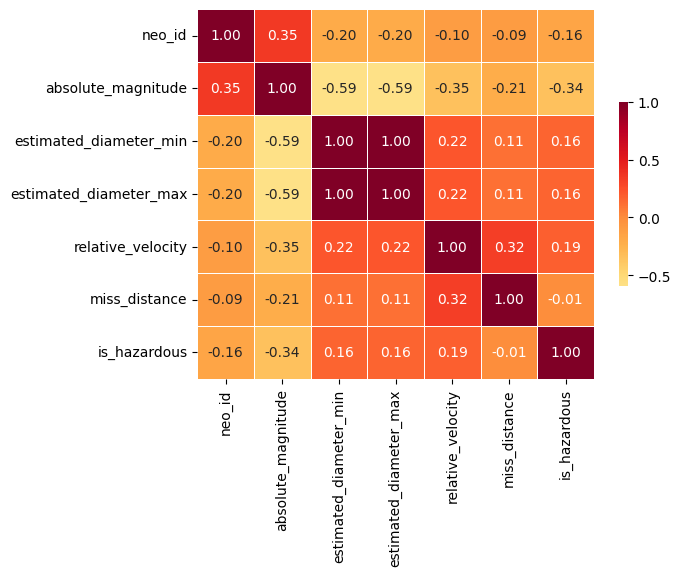

In [8]:
sns.heatmap(df.select_dtypes(include=["float", "int", "bool"]).corr(), annot=True, fmt=".2f", cmap='YlOrRd', center=0,
                linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

We can see the correlation between two features ***estimated_diameter_min*** & ***estimated_diameter_max***. The correlation has achived the maximum score of **1**, so there is a multilinear correlation. We can remove one of the features.

The ***miss_distance*** feature has almost no correlation at all with the target variable. It should be removed from the dataset, beacause it has no additional information.

### Analyzing the target variable

In [9]:
df['is_hazardous'].value_counts() / df.shape[0] * 100

is_hazardous
False    87.237691
True     12.762309
Name: count, dtype: float64

In [10]:
class_false = df[df['is_hazardous'] == False]
class_true = df[df['is_hazardous'] == True]

KEY_FEATS = ['absolute_magnitude', 'estimated_diameter_max', 'relative_velocity']

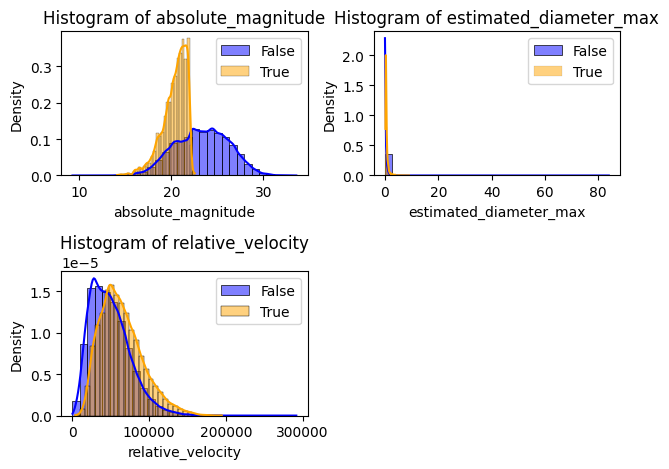

In [11]:
for i, feature in enumerate(KEY_FEATS, 1):
    plt.subplot(2, 2, i)
    sns.histplot(class_false[feature], label='False', color='blue', kde=True, stat='density', bins=30)
    sns.histplot(class_true[feature], label='True', color='orange', kde=True, stat='density', bins=30)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

### Handling NaNs

In [12]:
df.dropna(inplace=True)

In [13]:
df.shape

(338171, 9)

### Feature Selection

In [14]:
df.drop(columns=['neo_id', 'orbiting_body', 'name', 'estimated_diameter_min', 'miss_distance'], inplace=True)

In [15]:
df.columns

Index(['absolute_magnitude', 'estimated_diameter_max', 'relative_velocity',
       'is_hazardous'],
      dtype='object')

### Scaling numerical features

In [16]:
def applyScaling(X_train, X_test, y_train, y_test, scaler):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    train_arr = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
    test_arr = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

    return np.concatenate((train_arr, test_arr), axis=0)


In [17]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'is_hazardous'].values
y = df.loc[:, 'is_hazardous'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=74)

#### Normalization

In [18]:
from sklearn.preprocessing import Normalizer

normalized_df = pd.DataFrame(applyScaling(X_train, X_test, y_train, y_test, Normalizer()), columns=df.columns)
normalized_df['is_hazardous'] = normalized_df['is_hazardous'].astype(int)

#### Standardization

In [19]:
from sklearn.preprocessing import StandardScaler

standardized_df = pd.DataFrame(applyScaling(X_train, X_test, y_train, y_test, StandardScaler()), columns=df.columns)
standardized_df['is_hazardous'] = standardized_df['is_hazardous'].astype(int)

### Saving the data

In [20]:
normalized_df.to_csv('./data/normalized_data.csv', index=False)
standardized_df.to_csv('./data/standardized_data.csv', index=False)